In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [3]:
D = 1
out_node = 2
T = 0.01

directory1 = './1_dmftsolver/NRG'
if T == 0.001:
    add_dir = '_0.001'
    U_c1, U_c2 = 2.2, 2.59
elif T == 0.01:
    add_dir = '_0.01'
    U_c1, U_c2 = 2.2, 2.37

w_len = len(np.loadtxt(f'.{directory1}/1to4{add_dir}/Giw-{2.00:.2f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

U_i1, U_f2 = 100, 401
U_f1, U_i2 = int(U_c1*100), int(U_c2*100)

U_nrg = np.array([0.01*i for i in range(U_f1-50, U_i2+50)])
U1 = np.array([0.01*i for i in range(U_i1, U_f1)])
U2 = np.array([0.01*i for i in range(U_i2, U_f2)])

x1 = np.zeros((len(U1), w_len*2), dtype = 'float64')
x2 = np.zeros((len(U2), w_len*2), dtype = 'float64')
x_nrg = np.zeros((len(U_nrg)*2, w_len*2), dtype = 'float64')

# train + validation data
for i, u in enumerate(U1):
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory1}/1to4{add_dir}/Giw-{u:.2f}.dat', \
                                  unpack = True, dtype = 'float64')
    x1[i][:w_len], x1[i][w_len:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
for i, u in enumerate(U2):
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory1}/4to1{add_dir}/Giw-{u:.2f}.dat', \
                                  unpack = True, dtype = 'float64')
    x2[i][:w_len], x2[i][w_len:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
x = np.concatenate([x1, x2])
x = torch.FloatTensor(x)
x_size = len(x[0])

# test data
for i, u in enumerate(U_nrg):
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory1}/1to4{add_dir}/Giw-{u:.2f}.dat', \
                                  unpack = True, dtype = 'float64')
    x_nrg[i][:w_len], x_nrg[i][w_len:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory1}/4to1{add_dir}/Giw-{u:.2f}.dat', \
                                  unpack = True, dtype = 'float64')
    x_nrg[i+len(U_nrg)][:w_len], x_nrg[i+len(U_nrg)][w_len:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
x_nrg = torch.FloatTensor(x_nrg)

# Metal = 1, Insulator = 0
y_temp1 = np.array(U1 < U_c2)
y_temp2 = np.array(U2 <= U_c1)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)

y_temp1 = np.array(U_nrg < U_c2)
y_temp2 = np.array(U_nrg <= U_c1)
y_temp = np.concatenate([y_temp1, y_temp2])
y_nrg = np.stack([y_temp, ~y_temp], axis = 1)
y_nrg = torch.FloatTensor(y_nrg)

U_nrg = np.tile(U_nrg, 2)

In [14]:
directory2 = './1_dmftsolver/IPT/DMFT_IPT_SOLVER'
T_test = 0.02

if T_test==0.01:
    add_dir2 = '_0.01'
    U_ipt1 = np.array([2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.65,2.66,2.68,2.70])
    U_ipt2 = np.array([2.50,2.51,2.52,2.55,2.60,2.70,2.80,2.90,3.00,4.00])
    U_cc1, U_cc2 = 2.51, 2.66
if T_test==0.02:
    add_dir2 = '_0.02'
    U_ipt1 = np.array([2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.61,2.62,2.65])
    U_ipt2 = np.array([2.45,2.50,2.51,2.52,2.55,2.60,2.70,2.80,2.90,3.00,4.00])
    U_cc1, U_cc2 = 2.51, 2.62
    
w_len2 = len(np.loadtxt(f'.{directory2}/1to4{add_dir2}/Giw-2.00.dat', unpack=True, dtype='float64')[0])
x_ipt = np.zeros((len(U_ipt1)+len(U_ipt2), w_len2*2), dtype = 'float64')
for i,u in enumerate(U_ipt1):
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory2}/1to4{add_dir2}/Giw-{u:.2f}.dat', \
                                      unpack = True, dtype = 'float64')
    x_ipt[i][:w_len2], x_ipt[i][w_len2:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
for i,u in enumerate(U_ipt2):
    w, Giw_real, Giw_imag = np.loadtxt(f'.{directory2}/4to1{add_dir2}/Giw-{u:.2f}.dat', \
                                       unpack = True, dtype = 'float64')
    x_ipt[i+len(U_ipt1)][:w_len2], x_ipt[i+len(U_ipt1)][w_len2:] = ((D/2)**2*Giw_real), ((D/2)**2*Giw_imag)
x_ipt = torch.FloatTensor(x_ipt)

y_temp1 = np.array(U_ipt1 < U_cc2)
y_temp2 = np.array(U_ipt2 < U_cc1)
y_temp = np.concatenate([y_temp1, y_temp2])
y_ipt = np.stack([y_temp, ~y_temp], axis = 1)
y_ipt = torch.FloatTensor(y_ipt)

U_ipt = np.concatenate([U_ipt1, U_ipt2])

In [15]:
np.shape(x), np.shape(x_nrg), np.shape(x_ipt), np.shape(y), np.shape(y_nrg), np.shape(y_ipt)

(torch.Size([284, 10000]),
 torch.Size([234, 10000]),
 torch.Size([21, 10000]),
 torch.Size([284, 2]),
 torch.Size([234, 2]),
 torch.Size([21, 2]))

In [16]:
class Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(x_size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        return self.sig(self.W2(self.activate(self.W1(x)+self.b1.weight.data))+self.b2.weight.data)
    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)
    
class DNet(nn.Module):
    def __init__(self, node = None, activate = None):
        super(DNet, self).__init__()
        self.node = node
        self.W1 = nn.Linear(x_size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, self.node, bias=False)
        self.b2 = nn.Linear(self.node, 1, bias=False)
        self.W3 = nn.Linear(self.node, self.node, bias=False)
        self.b3 = nn.Linear(self.node, 1, bias=False)
        self.W4 = nn.Linear(self.node, out_node, bias=False)
        self.b4 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
            nn.init.xavier_normal_(self.W3.weight)
            nn.init.xavier_normal_(self.W4.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
            nn.init.kaiming_normal_(self.W3.weight)
            nn.init.kaiming_normal_(self.W4.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)
        self.b3.weight.data.fill_(0)
        self.b4.weight.data.fill_(0)

    def forward(self, x):
        a = self.activate(self.W2(self.activate(self.W1(x)+self.b1.weight.data))+self.b2.weight.data)
        return self.sig(self.W4(self.activate(self.W3(a)+self.b3.weight.data))+self.b4.weight.data)
    def loss1(self, output, y, reg): # regularization l1
        regular = torch.norm(self.W1.weight.data, p=1) \
                    + torch.norm(self.W2.weight.data, p=1) \
                    + torch.norm(self.W3.weight.data, p=1) \
                    + torch.norm(self.W4.weight.data, p=1)
        return F.binary_cross_entropy(output, y) + reg*regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = torch.norm(self.W1.weight.data)**2 \
                    + torch.norm(self.W2.weight.data)**2 \
                    + torch.norm(self.W3.weight.data)**2 \
                    + torch.norm(self.W4.weight.data)**2
        return F.binary_cross_entropy(output, y) + reg*regular # cross entropy loss
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

def divide(x_, y_):
    mask = np.random.rand(len(x_)) < 0.8  # train : val = 4 : 1
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val

def Net_plotting():
    print('epoch = %d, training loss = %.8f, accuracy = %.8f and %.8f' \
                  %(epoch, loss.item(), \
                    model.accuracy(model.forward(x_nrg), y_nrg),\
                    model.accuracy(model.forward(x_ipt), y_ipt) ))
    fig, ax = plt.subplots(1,3, figsize=(16, 4))
    ax[0].plot(U_nrg, model.forward(x_nrg).data[:,0], 'b.', label = 'trained')
    ax[0].plot(U_nrg, y_nrg[:,0], 'r.', ms = 2, label = 'actual')
    ax[0].legend()
    
    ax[1].plot(U_ipt, model.forward(x_ipt).data[:,0], 'b.', label = 'trained')
    ax[1].plot(U_ipt, y_ipt[:,0], 'r.', ms = 2, label = 'actual')
    ax[1].legend()
    
    ax[2].plot(np.arange(len(train_loss)), train_loss/np.max(val_loss), '-', label='train loss')
    ax[2].plot(np.arange(len(val_loss)), val_loss/np.max(val_loss), '-', label='validation')
    ax[2].plot(np.arange(len(test_acc)), test_acc, '-', label='test acc')
    ax[2].set_xlim(0, epoch)
    ax[2].legend()
    plt.show()
            
    fig, ax = plt.subplots(1, 2, figsize = (6, 5))
    im1 = ax[0].imshow(np.array(model.W1.weight.data).T, aspect=h_node/x_size*2, cmap='bwr')
    im2 = ax[1].imshow(np.array(model.W2.weight.data).T, aspect=10/h_node, cmap='bwr')
    cbar_ax = fig.add_axes([0.95, 0.2, 0.015, 0.4])
    cd = fig.colorbar(im1, cax = cbar_ax)
    plt.show()
    
def DNet_plotting():
    print('epoch = %d, training loss = %.8f, accuracy = %.8f and %.8f' \
                  %(epoch, loss.item(), \
                    model.accuracy(model.forward(x_nrg), y_nrg),\
                    model.accuracy(model.forward(x_ipt), y_ipt) ))
    fig, ax = plt.subplots(1,3, figsize=(16, 4))
    ax[0].plot(U_nrg, model.forward(x_nrg).data[:,0], 'b.', label = 'trained')
    ax[0].plot(U_nrg, y_nrg[:,0], 'r.', ms = 2, label = 'actual')
    ax[0].legend()
    ax[1].plot(U_ipt, model.forward(x_ipt).data[:,0], 'b.', label = 'trained')
    ax[1].plot(U_ipt, y_ipt[:,0], 'r.', ms = 2, label = 'actual')
    ax[1].legend()
    ax[2].plot(np.arange(len(train_loss)), train_loss/np.max(val_loss), '-', label='train loss')
    ax[2].plot(np.arange(len(val_loss)), val_loss/np.max(val_loss), '-', label='validation')
    ax[2].plot(np.arange(len(test_acc)), test_acc, '-', label='test acc')
    ax[2].set_xlim(0, epoch)
    ax[2].legend()
    plt.show()
            
    fig, ax = plt.subplots(1, 4, figsize = (15, 5))
    im1 = ax[0].imshow(np.array(model.W1.weight.data).T, aspect=h_node/x_size*2, cmap='bwr')
    im2 = ax[1].imshow(np.array(model.W2.weight.data), aspect=1, cmap='bwr')
    im3 = ax[2].imshow(np.array(model.W3.weight.data), aspect=1, cmap='bwr')
    im4 = ax[3].imshow(np.array(model.W4.weight.data).T, aspect=10/h_node, cmap='bwr')
    cbar_ax = fig.add_axes([0.95, 0.2, 0.015, 0.4])
    cd = fig.colorbar(im1, cax = cbar_ax)
    plt.show()

epoch = 0, training loss = 0.92851734, accuracy = 0.50000000
epoch = 100, training loss = 0.66814440, accuracy = 0.96367521
epoch = 200, training loss = 0.76797163, accuracy = 0.98076923
epoch = 300, training loss = 0.86801219, accuracy = 0.98717949
epoch = 400, training loss = 0.93067539, accuracy = 0.98717949
epoch = 500, training loss = 0.97991246, accuracy = 0.98717949
epoch = 600, training loss = 1.01794648, accuracy = 0.98717949
epoch = 700, training loss = 1.05260098, accuracy = 0.98717949
epoch = 800, training loss = 1.07533991, accuracy = 0.98931624
epoch = 900, training loss = 1.09962511, accuracy = 0.98717949
epoch = 1000, training loss = 1.11880231, accuracy = 0.98931624
epoch = 1000, training loss = 1.11880231, accuracy = 0.98931624 and 0.52380952


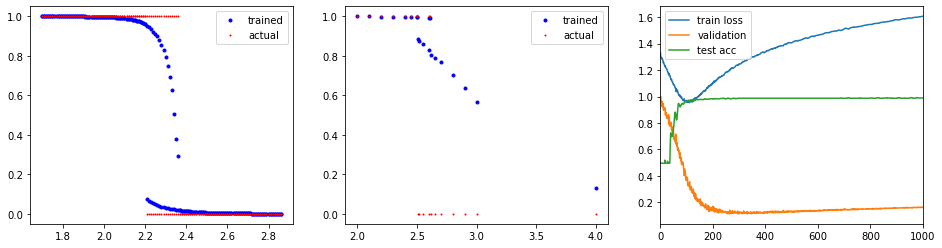

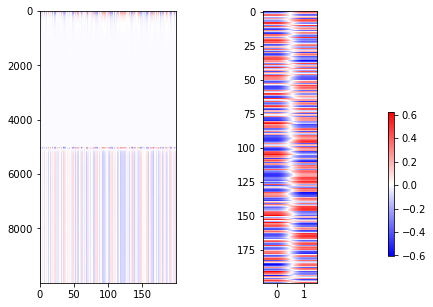

In [21]:
learning_rate = 1e-3
reg = 1e-5
h_node = 200
func = nn.Sigmoid # activation function
model = Net(node = h_node, activate = func)

# Begin training and validation
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
n_epochs = 1000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    x_train, x_val, y_train, y_val = divide(x, y)
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss2(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_nrg), y_nrg)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.8f, accuracy = %.8f' \
                %(epoch, loss.item(), t_acc))
    '''if epoch > 50:
        if (valid_loss > val_loss[epoch-50] or epoch==n_epochs): 
            plotting()    
            break'''
Net_plotting()

epoch = 0, training loss = 0.83034194, accuracy = 0.50000000
epoch = 100, training loss = 0.71620309, accuracy = 0.49572650
epoch = 200, training loss = 0.55232441, accuracy = 0.92094017
epoch = 300, training loss = 0.31862912, accuracy = 0.98717949
epoch = 400, training loss = 0.30242121, accuracy = 0.98717949
epoch = 500, training loss = 0.30106729, accuracy = 0.98717949
epoch = 600, training loss = 0.30160171, accuracy = 0.99145299
epoch = 700, training loss = 0.30310434, accuracy = 0.99145299
epoch = 800, training loss = 0.30394343, accuracy = 0.99145299
epoch = 900, training loss = 0.30578396, accuracy = 0.99145299
epoch = 1000, training loss = 0.30679482, accuracy = 0.99145299
epoch = 1000, training loss = 0.30679482, accuracy = 0.99145299 and 0.47619048


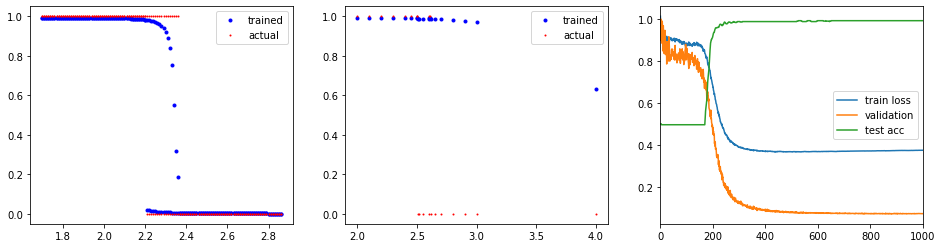

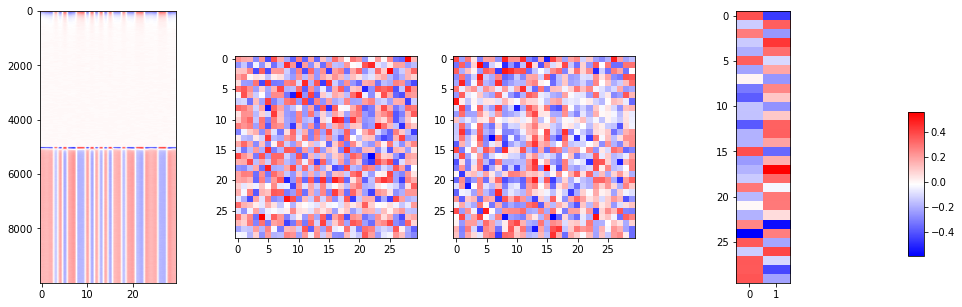

In [22]:
learning_rate = 1e-3
reg = 1e-5
h_node = 30
func = nn.Sigmoid # activation function
model = DNet(node = h_node, activate = func)

# Begin training and validation
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
n_epochs = 1000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    x_train, x_val, y_train, y_val = divide(x, y)
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss2(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_nrg), y_nrg)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.8f, accuracy = %.8f' \
                %(epoch, loss.item(), t_acc))
    '''if epoch > 50:
        if (valid_loss > val_loss[epoch-50] or epoch==n_epochs): 
            plotting()    
            break'''
DNet_plotting()